# Travel Insurance
??
***

### Business Problem Understanding
***

##### **Background**

Travel insurance is an insurance product for covering any losses while traveling, such as flight delay, loss luggage, trip cancellation, and more. Travel insurance companies offer various plans based on type of losses that can be claimed. In this problem, a travel insurance company aims to predict whether a policyholder will file a claim. This insight helps the company focus on groups less likely to file claims, thereby maximizing profits.

Target feature:     
0&emsp;:&ensp;Won't submit an insurance claim       
1&emsp;&nbsp;:&ensp;Will submit an insurance claim

##### **Problem Statement**

There are some accidents that couldn't be predicted whether a complain will be filed or not, such as:
- Delayed / canceled flight due to bad weather,
- Lost item due to pickpocket,
- Illness due to extreme weather in destination country,
- etc.

##### **Goals**

Based on the problem statement, 


This company aims to predict whether policyholder will file a claim

Also the variables that 

pengen tahu siapa yang bakal file a claim, 

faktor apa aja yang bikin orang itu bakal claim, jadi bisa membuat strategi untuk memaksimalkan profitnya

##### **Metric Evaluation**

### Data Understanding
***

##### **Import libraries**

In [836]:
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, RobustScaler, KBinsDiscretizer, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.decomposition import PCA

# Model Selection
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, recall_score, precision_score, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.ensemble import BalancedRandomForestClassifier

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

##### **Attribute Information**

| Attribute | Data Type, Length | Description |
| --- | --- | --- |
| Agency | Text | Name of agency |
| Agency Type | Text | Type of travel insurance agencies |
| Distribution Channel | Text | Channel of travel insurance agencies |
| Product Name | Text | Name of travel insurance products |
| Gender | Text | Gender of insured |
| Duration | Integer | Duration of travel |
| Destination | Text | Destination of travel |
| Net Sales | Float | Amount of travel insurance policies |
| Commission (in value) | Float | Commission received for travel insurance agency |
| Age | Integer | Age of insured |
| Claim | Text | Claim status |

##### **Import dataset**

In [837]:
df = pd.read_csv('./data_travel_insurance.csv')

display(df.head(), df.tail())

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,No


,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,14,CHINA,30.0,0.00,36,Yes
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,17,AUSTRALIA,79.2,47.52,47,No
44325,TST,Travel Agency,Offline,Travel Cruise Protect,M,64,THAILAND,30.0,10.50,50,No
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,51,CHINA,36.0,0.00,36,No
44327,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,172,SINGAPORE,0.0,17.82,31,No


##### **Dataset Information**

In [838]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency Type           44328 non-null  object 
 2   Distribution Channel  44328 non-null  object 
 3   Product Name          44328 non-null  object 
 4   Gender                12681 non-null  object 
 5   Duration              44328 non-null  int64  
 6   Destination           44328 non-null  object 
 7   Net Sales             44328 non-null  float64
 8   Commision (in value)  44328 non-null  float64
 9   Age                   44328 non-null  int64  
 10  Claim                 44328 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB


### Data Cleaning
***

In [839]:
cleaned_df = df.copy()

display(cleaned_df.describe(include='object'), cleaned_df.describe(include='number'))

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Destination,Claim
count,44328,44328,44328,44328,12681,44328,44328
unique,16,2,2,26,2,138,2
top,EPX,Travel Agency,Online,Cancellation Plan,M,SINGAPORE,No
freq,24656,32113,43572,12979,6504,9267,43651


,Duration,Net Sales,Commision (in value),Age
count,44328.000000,44328.000000,44328.000000,44328.000000
mean,49.424292,40.550948,9.707692,39.925600
std,109.153961,48.661970,19.625637,13.954926
min,-1.000000,-357.500000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.500000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


##### **Duplicate Values**

In [840]:
df_shape = df.shape
duplicated_values_count = cleaned_df.duplicated().sum()

display(f"Original data shape: {df_shape}",
    f"Duplicated values count: {duplicated_values_count}",
    f"Percentage of duplicated values: { duplicated_values_count / df_shape[0] * 100 }%")

'Original data shape: (44328, 11)'

'Duplicated values count: 4667'

'Percentage of duplicated values: 10.528334235697526%'

In [841]:
'''
Even though the duplicated value counts seems big, these data only represents 10% of the original data.
So it is better to drop whole duplicated values than to disrupt the ML accuracy.
'''

cleaned_df.drop_duplicates(inplace=True)

print(f"Cleaned data shape after removing duplicates: {cleaned_df.shape}")

Cleaned data shape after removing duplicates: (39661, 11)


##### **Missing Values**

In [842]:
missingVal = cleaned_df.isna().sum()
missingVal[missingVal > 0]

Gender    27667
dtype: int64

In [843]:
print(f"Percentage of missing values: { cleaned_df['Gender'].isna().sum() / cleaned_df.shape[0] * 100}%")

Percentage of missing values: 69.75870502508762%


In [844]:
'''
Given the high percentage of missing values in Gender column, it is reasonable to drop this column entirely.
In the context of travel claims, it is assumed that gender is unlikely to influence whether a claim is filed, as travel losses are typically caused by external factors such as natural disaster, or other.
'''

cleaned_df.drop(columns='Gender', axis=1, inplace=True)

##### **Numerical Outliers**

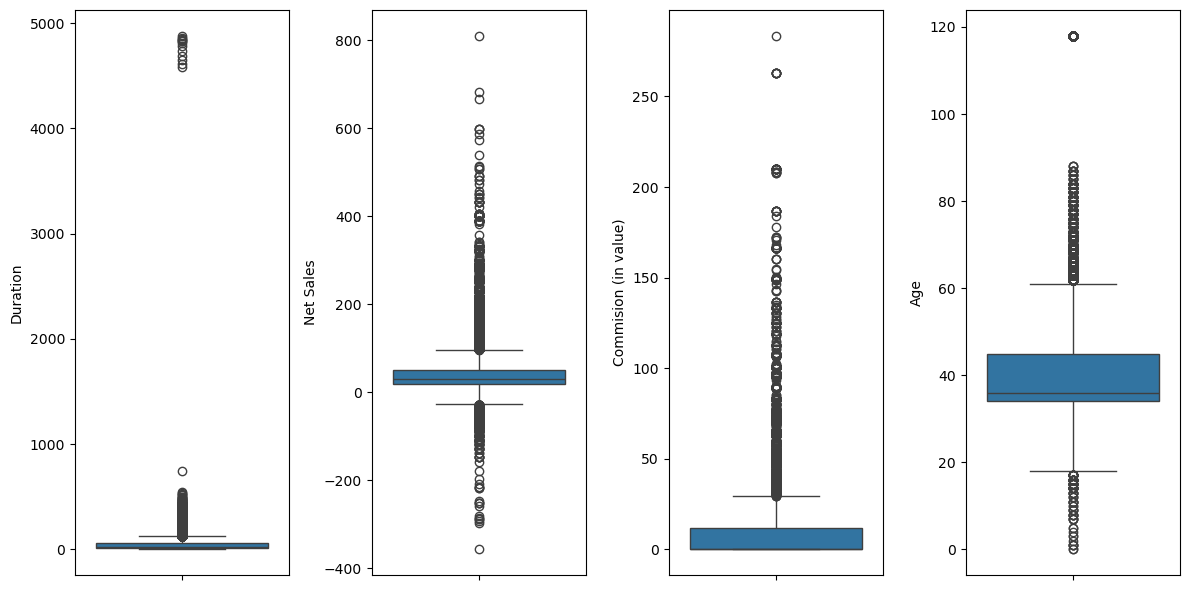

In [845]:
plt.figure(figsize=(12, 6))
for i, column in enumerate(cleaned_df.describe(include='number'), 1):
    plt.subplot(1, 4, i)
    sns.boxplot(data=cleaned_df[column])
plt.tight_layout()
plt.show()

In [846]:
'''
Remove global / extreme outliers in numerical columns
'''

original_cleaned_df_shape = cleaned_df.shape

cleaned_df = cleaned_df[(cleaned_df['Duration'] < 600) & (cleaned_df['Net Sales'] <= 600) &
                        (cleaned_df['Net Sales'] >= 0) & (cleaned_df['Age'] < 100) & (cleaned_df['Age'] > 0)]

print(f"Original cleaned df shape: { original_cleaned_df_shape }")
print(f"Number of removed values:  { original_cleaned_df_shape[0] - cleaned_df.shape[0] }")
print(f"Cleaned df shape after removing outliers using IQR method: { cleaned_df.shape }",)
print(f"Percentage of removed values: { ( original_cleaned_df_shape[0] - cleaned_df.shape[0] ) / original_cleaned_df_shape[0] * 100 }%")

Original cleaned df shape: (39661, 10)
Number of removed values:  965
Cleaned df shape after removing outliers using IQR method: (38696, 10)
Percentage of removed values: 2.433120697914828%


In [847]:
'''
Iteratively removing outliers
'''

original_cleaned_df_shape = cleaned_df.shape

cleaned_df = cleaned_df[(cleaned_df['Duration'] < 500) & (cleaned_df['Net Sales'] <= 400) & (cleaned_df['Age'] < 80)]

print(f"Original cleaned df shape: { original_cleaned_df_shape }")
print(f"Number of removed values:  { original_cleaned_df_shape[0] - cleaned_df.shape[0] }")
print(f"Cleaned df shape after removing outliers using IQR method: { cleaned_df.shape }",)
print(f"Percentage of removed values: { ( original_cleaned_df_shape[0] - cleaned_df.shape[0] ) / original_cleaned_df_shape[0] * 100 }%")

Original cleaned df shape: (38696, 10)
Number of removed values:  124
Cleaned df shape after removing outliers using IQR method: (38572, 10)
Percentage of removed values: 0.32044655778375025%


In [848]:
'''
Removing the rest of outliers using IQR method
'''

def count_outliers(data):
    data = np.array(data)
    
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return {'lower_bound': lower_bound, 'upper_bound': upper_bound}

original_cleaned_df_shape = cleaned_df.shape

age_outliers = count_outliers(cleaned_df['Age'])
cleaned_df = cleaned_df[(cleaned_df['Age'] >= age_outliers['lower_bound']) & 
                        (cleaned_df['Age'] <= age_outliers['upper_bound'])]

duration_outliers = count_outliers(cleaned_df['Duration'])
cleaned_df = cleaned_df[(cleaned_df['Duration'] >= duration_outliers['lower_bound']) & 
                        (cleaned_df['Duration'] <= duration_outliers['upper_bound'])]

net_sales_outliers = count_outliers(cleaned_df['Net Sales'])
cleaned_df = cleaned_df[(cleaned_df['Net Sales'] >= net_sales_outliers['lower_bound']) & 
                        (cleaned_df['Net Sales'] <= net_sales_outliers['upper_bound'])]

print(f"Original cleaned df shape: { original_cleaned_df_shape }")
print(f"Number of removed values:  { original_cleaned_df_shape[0] - cleaned_df.shape[0] }")
print(f"Cleaned df shape after removing outliers using IQR method: { cleaned_df.shape }",)
print(f"Percentage of removed values: { ( original_cleaned_df_shape[0] - cleaned_df.shape[0] ) / original_cleaned_df_shape[0] * 100 }%")

Original cleaned df shape: (38572, 10)
Number of removed values:  7194
Cleaned df shape after removing outliers using IQR method: (31378, 10)
Percentage of removed values: 18.65083480244737%


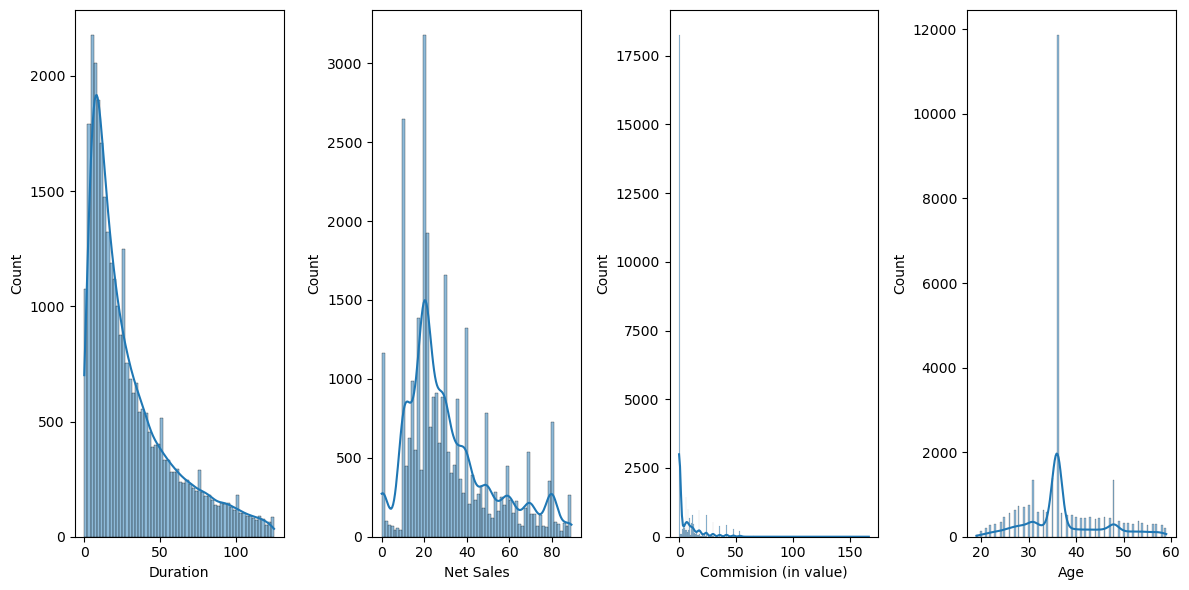

In [849]:
plt.figure(figsize=(12, 6))
for i, column in enumerate(cleaned_df.describe(include='number'), 1):
    plt.subplot(1, 4, i)
    sns.histplot(data=cleaned_df[column], kde=True)
plt.tight_layout()
plt.show()

##### **Categorical Outliers**

<function matplotlib.pyplot.show(close=None, block=None)>

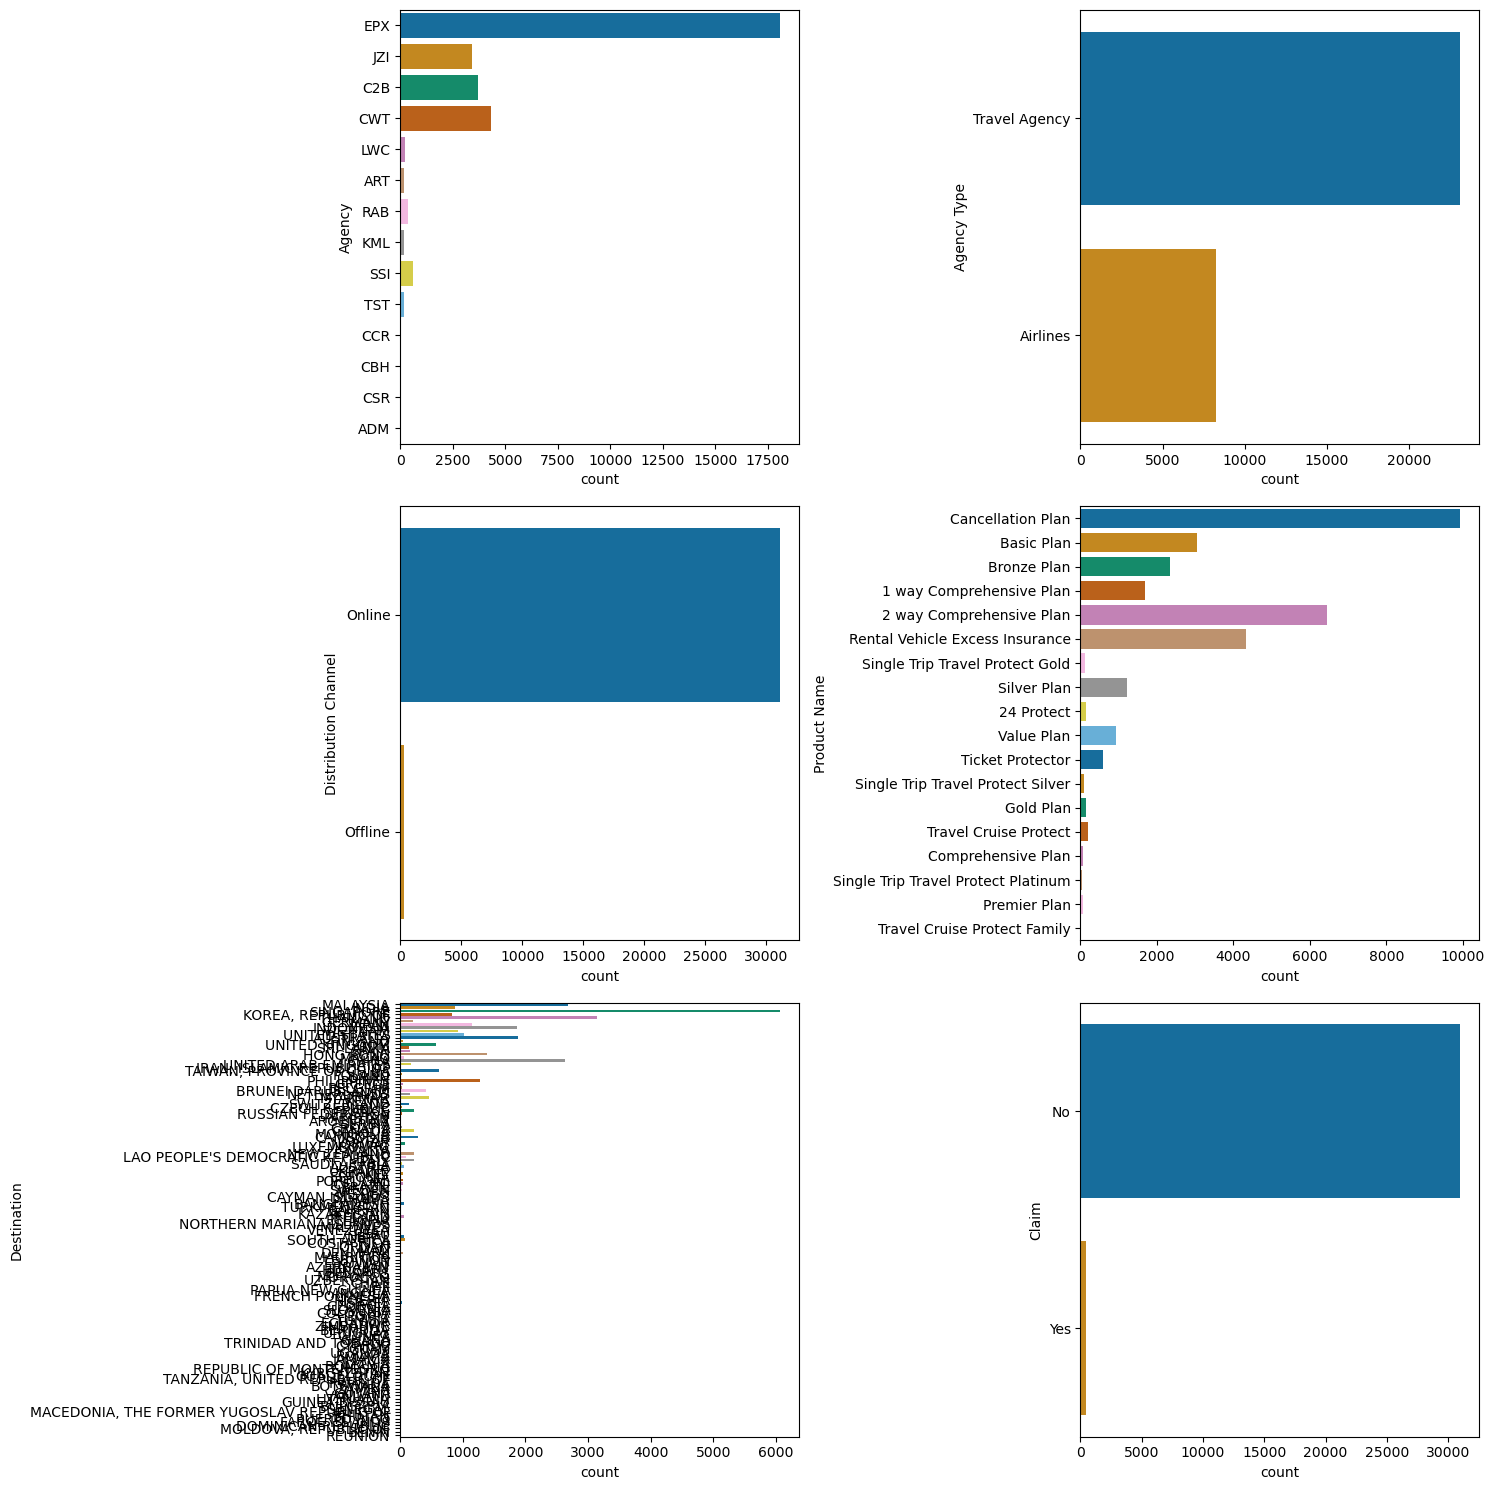

In [850]:
plt.figure(figsize=(15, 15))
for i, column in enumerate(cleaned_df.describe(include='object'), 1):
    plt.subplot(3, 2, i)
    sns.countplot(data=cleaned_df[column], palette='colorblind')
plt.tight_layout()
plt.show

In [851]:
display(cleaned_df.describe(include='object'), cleaned_df.describe(include='number'))

,Agency,Agency Type,Distribution Channel,Product Name,Destination,Claim
count,31378,31378,31378,31378,31378,31378
unique,14,2,2,18,131,2
top,EPX,Travel Agency,Online,Cancellation Plan,SINGAPORE,No
freq,18049,23110,31075,9918,6059,30956


,Duration,Net Sales,Commision (in value),Age
count,31378.000000,31378.000000,31378.000000,31378.000000
mean,30.213589,31.590657,6.483622,37.361846
std,27.800095,20.629146,11.206764,8.021066
min,0.000000,0.000000,0.000000,19.000000
25%,9.000000,18.000000,0.000000,34.000000
50%,20.000000,26.000000,0.000000,36.000000
75%,42.000000,40.000000,9.100000,40.000000
max,125.000000,89.100000,166.320000,59.000000


### Feature Engineering
***

##### **Categorical Columns**

In [852]:
cleaned_df.describe(include='object')

,Agency,Agency Type,Distribution Channel,Product Name,Destination,Claim
count,31378,31378,31378,31378,31378,31378
unique,14,2,2,18,131,2
top,EPX,Travel Agency,Online,Cancellation Plan,SINGAPORE,No
freq,18049,23110,31075,9918,6059,30956


In [853]:
for column in cleaned_df.describe(include='object'):
    display(cleaned_df[column].value_counts().head())

Agency
EPX    18049
CWT     4338
C2B     3692
JZI     3437
SSI      590
Name: count, dtype: int64

Agency Type
Travel Agency    23110
Airlines          8268
Name: count, dtype: int64

Distribution Channel
Online     31075
Offline      303
Name: count, dtype: int64

Product Name
Cancellation Plan                  9918
2 way Comprehensive Plan           6433
Rental Vehicle Excess Insurance    4338
Basic Plan                         3050
Bronze Plan                        2345
Name: count, dtype: int64

Destination
SINGAPORE    6059
THAILAND     3148
MALAYSIA     2682
CHINA        2635
AUSTRALIA    1880
Name: count, dtype: int64

Claim
No     30956
Yes      422
Name: count, dtype: int64

In [854]:
'''
One hot encoding: Agency Type, Distribution Channel
Label encoding: Claim
Binary: Agency, Product Name, Destination

Ordinal encoding not used for any columns because there are no sequence
'''

categorical_transformer = [
    ('onehot', OneHotEncoder(drop='first'), ['Agency Type', 'Distribution Channel']),
    ('binary', ce.BinaryEncoder(), ['Agency', 'Product Name', 'Destination']),
]

##### **Numerical Columns**

In [855]:
cleaned_df.describe(include='number')

,Duration,Net Sales,Commision (in value),Age
count,31378.000000,31378.000000,31378.000000,31378.000000
mean,30.213589,31.590657,6.483622,37.361846
std,27.800095,20.629146,11.206764,8.021066
min,0.000000,0.000000,0.000000,19.000000
25%,9.000000,18.000000,0.000000,34.000000
50%,20.000000,26.000000,0.000000,36.000000
75%,42.000000,40.000000,9.100000,40.000000
max,125.000000,89.100000,166.320000,59.000000


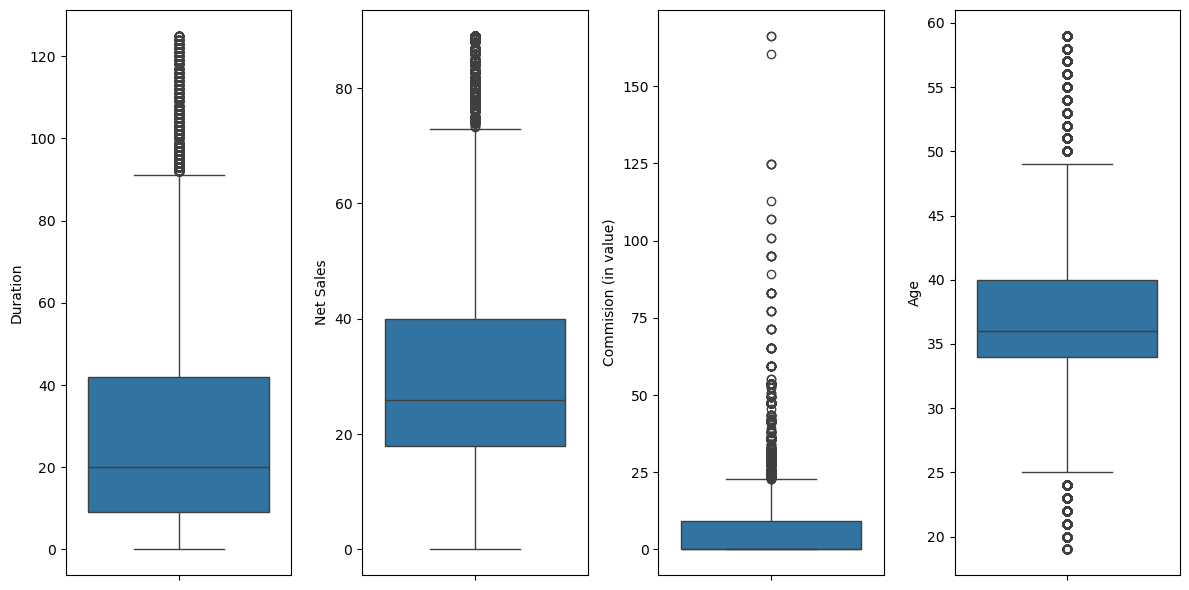

In [856]:
plt.figure(figsize=(12, 6))
for i, column in enumerate(cleaned_df.describe(include='number'), 1):
    plt.subplot(1, 4, i)
    sns.boxplot(data=cleaned_df[column])
plt.tight_layout()
plt.show()

In [857]:
def commission_binning(X):
    return (X > 0).astype(int)

In [858]:
'''
Binning: Commission
-> Extremely skewed. Many zero values shown by Q1 and Q3

Robust Scaler: Net sales, Duration
-> Because these columns have big amount of outliers
'''

numerical_transformer = [
    ('robust', RobustScaler(), ['Net Sales', 'Duration']),
    ('binning', FunctionTransformer(commission_binning), ['Commision (in value)']),
]

##### **Data Split**

In [859]:
X = cleaned_df.drop(columns=['Claim'])
y = cleaned_df['Claim']

In [860]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [861]:
feature_engineering_transformer = ColumnTransformer(
    numerical_transformer + categorical_transformer,
    remainder='passthrough'
)

X_train_prep = feature_engineering_transformer.fit_transform(X_train)
X_test_prep = feature_engineering_transformer.transform(X_test)

In [862]:
columns_name = []

for i in range(5):
    if i == 1:
        columns_name += ['Commision (in value)']
        continue
    
    columns_name += list(feature_engineering_transformer.transformers_[i][1].get_feature_names_out())

X_train_prep = pd.DataFrame(X_train_prep)
X_test_prep = pd.DataFrame(X_test_prep)

X_train_prep.columns = columns_name
X_test_prep.columns = columns_name

In [863]:
X_train_prep.head()

,Net Sales,Duration,Commision (in value),Agency Type_Travel Agency,Distribution Channel_Online,Agency_0,Agency_1,Agency_2,Agency_3,Product Name_0,Product Name_1,Product Name_2,Product Name_3,Product Name_4,Destination_0,Destination_1,Destination_2,Destination_3,Destination_4,Destination_5,Destination_6,Age
0,-0.272727,-0.454545,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,35.0
1,-0.272727,-0.242424,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,30.0
2,0.318182,-0.151515,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,36.0
3,0.272727,-0.060606,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,36.0
4,0.045455,-0.363636,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,36.0


### Feature Selection
***

In [864]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_prep, y_train)

feature_importances = xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train_prep.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df

,Feature,Importance
7,Agency_2,0.301337
8,Agency_3,0.248576
9,Product Name_0,0.034429
3,Agency Type_Travel Agency,0.030917
13,Product Name_4,0.030230
19,Destination_5,0.026306
17,Destination_3,0.026022
16,Destination_2,0.025031
5,Agency_0,0.024928
18,Destination_4,0.024849


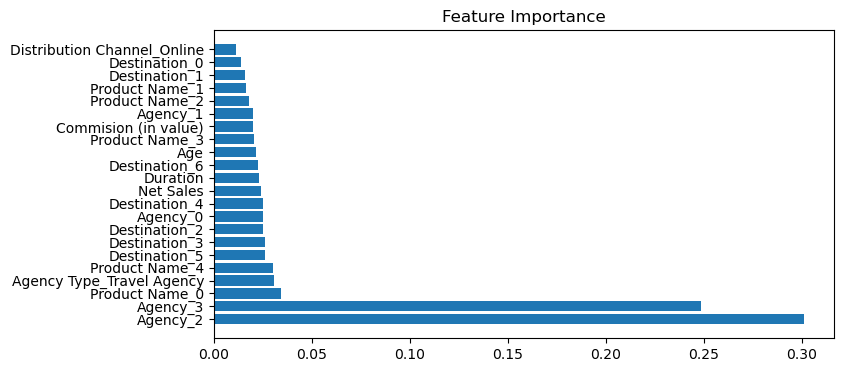

In [865]:
plt.figure(figsize=(8, 4))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.title('Feature Importance')
plt.show()

In [ ]:
'''
Count the cumulative importance because shown a big gap between Agency_3 and Product Name_0 features
Choosing by only top 5 importance features won't be appropriate. Set the threshold to 85%
'''

feature_importance_df['Cumulative_Importance'] = feature_importance_df['Importance'].cumsum()

threshold = 0.85
selected_features = feature_importance_df[feature_importance_df['Cumulative_Importance'] <= threshold]['Feature'].values

print(f"Selected features: {selected_features}")

X_train_prep = X_train_prep[selected_features]
X_test_prep = X_test_prep[selected_features]

Selected features: ['Agency_2' 'Agency_3' 'Product Name_0' 'Agency Type_Travel Agency'
 'Product Name_4' 'Destination_5' 'Destination_3' 'Destination_2'
 'Agency_0' 'Destination_4' 'Net Sales' 'Duration' 'Destination_6']


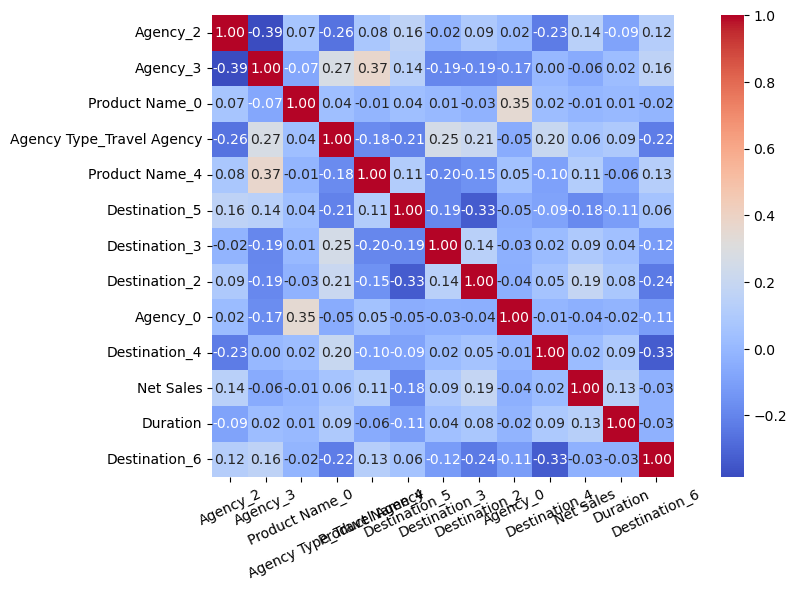

In [867]:
plt.figure(figsize=(12,6))
sns.heatmap(X_train_prep.select_dtypes(include=np.number).corr(), cmap='coolwarm', annot=True, fmt=".2f", square=True)
plt.xticks(rotation=25)
plt.show()

From the correlation heatmap shown above, shown that PCA shouldn't be done on this dataset.     
Even though there are some high correlation shown by these features: Product Name_3 with Agency Type_Travel Agency (-0.49),     
Since there are only 7 features left on this dataset and most features has low correlation (almost 0)

### Modeling
***

##### **Model Benchmark to Train Data**

In [868]:
algorithm_list = [LogisticRegression(), KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier(), XGBClassifier()]

algorithm_list_name = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGB']

In [869]:
score_list_precision = []
mean_list_precision = []
std_list_precision = []

score_list_roc_auc = []
mean_list_roc_auc = []
std_list_roc_auc = []

for algorithm in algorithm_list:
    cv_score_precision = cross_val_score(
        estimator = algorithm,
        X = X_train_prep,
        y = y_train,
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='precision'
    )
    
    cv_score_roc = cross_val_score(
        estimator = algorithm,
        X = X_train_prep,
        y = y_train,
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='roc_auc'
    )
    
    score_list_precision.append(cv_score_precision)
    mean_list_precision.append(cv_score_precision.mean())
    std_list_precision.append(cv_score_precision.std())
    
    score_list_roc_auc.append(cv_score_roc)
    mean_list_roc_auc.append(cv_score_roc.mean())
    std_list_roc_auc.append(cv_score_roc.std())

In [870]:
'''
TP : Actual 1, Predicted 1
FP : Actual 0, Predicted 1 ( Type I Error )
TN : Actual 0, Predicted 0
FN : Actual 1, Predicted 0 ( Type II Error )

Precision is used because the company goal is to maximize its profit by focusing on groups that less likely file a claim.
Means to minimize the FP (False Positive)
'''

cv_score_df = pd.DataFrame()
cv_score_df['Model'] = algorithm_list_name
cv_score_df['Mean Precision'] = mean_list_precision
cv_score_df['Std Precision'] = std_list_precision
cv_score_df['Mean ROC AUC'] = mean_list_roc_auc
cv_score_df['Std ROC AUC'] = std_list_roc_auc

cv_score_df = cv_score_df.set_index('Model')
cv_score_df.sort_values(by='Mean ROC AUC', ascending=False)

,Mean Precision,Std Precision,Mean ROC AUC,Std ROC AUC
Model,,,,
Logistic Regression,0.000000,0.000000,0.794143,0.020431
XGB,0.366667,0.371184,0.763892,0.020930
Random Forest,0.070098,0.044606,0.645644,0.025884
KNN,0.083333,0.105409,0.568925,0.019129
Decision Tree,0.065256,0.022072,0.560803,0.014397


Logistic Regression has the highest ROC AUC score meaning that it is the best algorithms so far even when the precision value is 0.       
For now, let's assume the precision value is 0 is caused by imbalanced dataset.      

##### **Model Benchmark to Test Data**

In [871]:
fpr_score_list = []
tpr_score_list = []
auc_score_list = []
cm_list = []

for algorithm in algorithm_list:
    clf = algorithm.fit(X_train_prep, y_train)
    y_pred = clf.predict(X_test_prep)
    y_pred_proba = clf.predict_proba(X_test_prep)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    cm = metrics.confusion_matrix(y_test, y_pred)
    
    fpr_score_list.append(fpr)
    tpr_score_list.append(tpr)
    auc_score_list.append(auc)
    cm_list.append(cm)

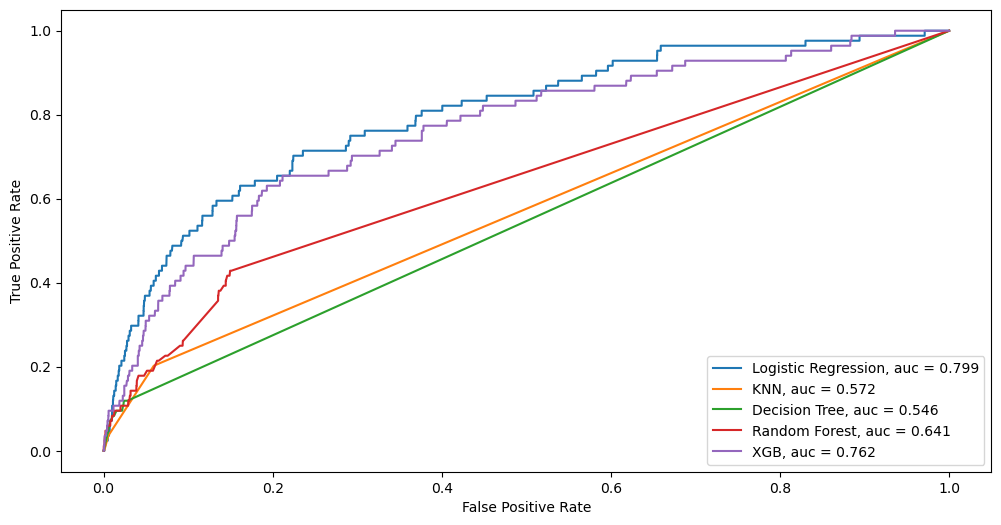

In [872]:
plt.figure(figsize=(12, 6))

for index in range(len(algorithm_list)):
    plt.plot(fpr_score_list[index], tpr_score_list[index], label=f"{algorithm_list_name[index]}, auc = {auc_score_list[index]:.3f}")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

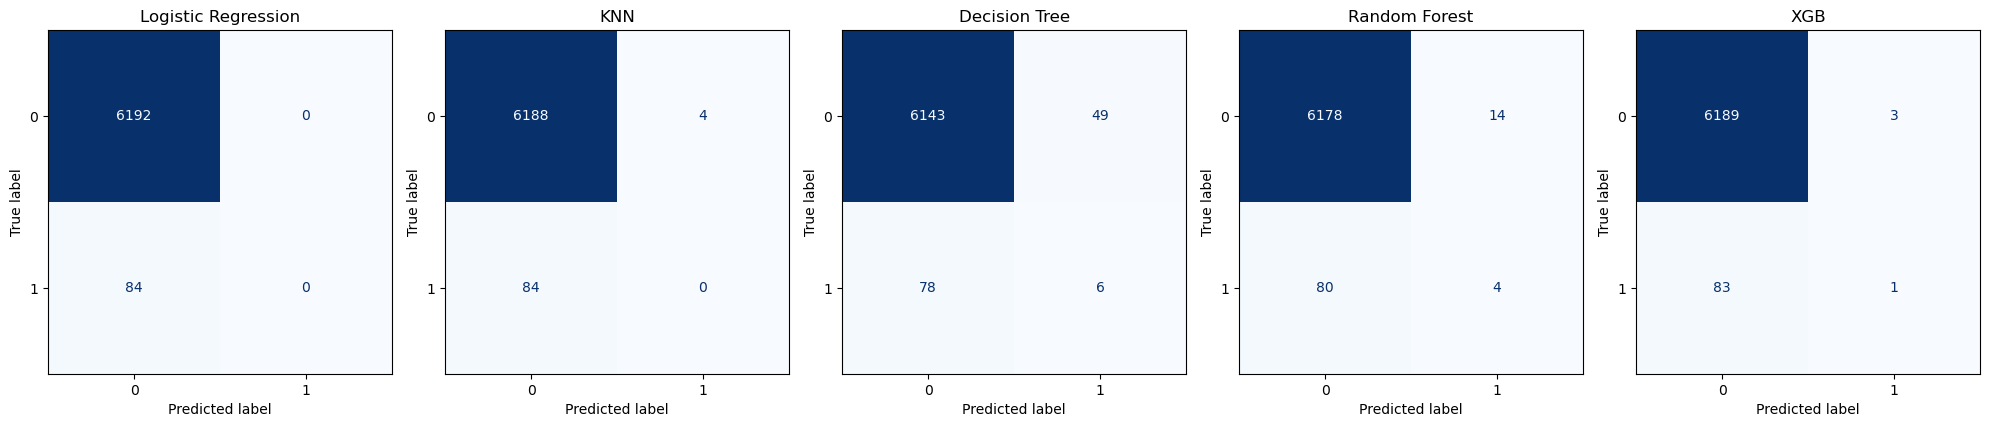

In [873]:
fig, axes = plt.subplots(1, len(cm_list), figsize=(len(cm_list) * 4, 4))

for i, (cm, ax) in enumerate(zip(cm_list, axes), 0):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
    ax.set_title(algorithm_list_name[i])

plt.tight_layout()
plt.show()

From the test data, XGB has the highest ROC AUC score, followed by Logistic Regression which is 0.03 score behind.      
Therefore XGB will be used since it shows that this algorithm performs well accross different datasets and generalizes better to new data.

##### **Oversampling**

**SMOTE**

In [874]:
y_value_counts = np.unique(y, return_counts=True)

y_value_counts_df = pd.DataFrame()
y_value_counts_df["Target"] = y_value_counts[0]
y_value_counts_df["Count"] = y_value_counts[1]
y_value_counts_df["Percentage"] = [(y_value_counts[1][0]/len(y) * 100), (y_value_counts[1][1]/len(y) * 100)]

y_value_counts_df.set_index('Target')

,Count,Percentage
Target,,
0,30956,98.655109
1,422,1.344891


In [875]:
sm = SMOTE()

X_train_smote, y_train_smote = sm.fit_resample(X_train_prep, y_train)

In [876]:
y_smote_value_counts = np.unique(y_train_smote, return_counts=True)

y_smote_value_counts_df = pd.DataFrame()
y_smote_value_counts_df["Target"] = y_smote_value_counts[0]
y_smote_value_counts_df["Count"] = y_smote_value_counts[1]
y_smote_value_counts_df["Percentage"] = (y_smote_value_counts[1] / len(y_train_smote) * 100)

y_smote_value_counts_df.set_index('Target')

,Count,Percentage
Target,,
0,24764,50.0
1,24764,50.0


### Evaluation
***

In [877]:
def model_metrics(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_train_proba = model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else None
    y_test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    train_roc_auc = roc_auc_score(y_train, y_train_proba) if y_train_proba is not None else "N/A"
    test_roc_auc = roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else "N/A"
    
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    
    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)
    
    train_precision = precision_score(y_train, y_train_pred)
    test_precision = precision_score(y_test, y_test_pred)
    
    train_cm = confusion_matrix(y_train, y_train_pred)
    test_cm = confusion_matrix(y_test, y_test_pred)
    
    result_df = pd.DataFrame()
    result_df['Metric'] = ['Accuracy', 'ROC AUC', 'F1 Score', 'Recall', 'Precission']
    result_df['Train'] = [f"{train_accuracy:<20.4f}", f"{train_roc_auc:<20.4f}", f"{train_f1:<20.4f}", f"{train_recall:<20.4f}", f"{train_precision:<20.4f}"]
    result_df['Test'] = [f"{test_accuracy:<20.4f}", f"{test_roc_auc:<20.4f}", f"{test_f1:<20.4f}", f"{test_recall:<20.4f}", f"{test_precision:<20.4f}"]
    result_df = result_df.set_index('Metric')
    
    return {"metrics": result_df, "train_cm": train_cm, "test_cm": test_cm}

##### **Evaluation Metrics without Oversampling**

In [878]:
xgb = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')

xgb_default = xgb.fit(X_train_prep, y_train)

result = model_metrics(xgb_default, X_train_prep, y_train, X_test_prep, y_test)

result['metrics']

,Train,Test
Metric,,
Accuracy,0.9875,0.9863
ROC AUC,0.9738,0.7623
F1 Score,0.1326,0.0227
Recall,0.0710,0.0119
Precission,1.0000,0.2500


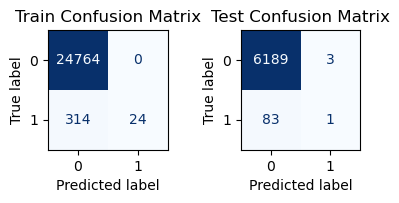

In [879]:
fig, axes = plt.subplots(1, 2, figsize=(2 * 2, 2))

for i, (cm, ax) in enumerate(zip([result['train_cm'], result['test_cm']], axes), 0):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
    ax.set_title(["Train Confusion Matrix", "Test Confusion Matrix"][i])

plt.tight_layout()
plt.show()

##### **Evaluation Metrics with Oversampling**

In [880]:
xgb = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')

xgb_oversampling = xgb.fit(X_train_smote, y_train_smote)

result_oversampling = model_metrics(xgb_oversampling, X_train_smote, y_train_smote, X_test_prep, y_test)

result_oversampling['metrics']

,Train,Test
Metric,,
Accuracy,0.9630,0.9359
ROC AUC,0.9945,0.7559
F1 Score,0.9634,0.0822
Recall,0.9754,0.2143
Precission,0.9517,0.0508


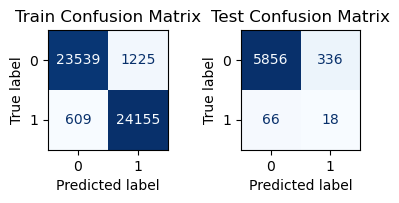

In [881]:
fig, axes = plt.subplots(1, 2, figsize=(2 * 2, 2))

for i, (cm, ax) in enumerate(zip([result_oversampling['train_cm'], result_oversampling['test_cm']], axes), 0):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
    ax.set_title(["Train Confusion Matrix", "Test Confusion Matrix"][i])

plt.tight_layout()
plt.show()

From the comparison between original and oversampled data shown that the evaluation metrics on original data is better.     
But from the confusion matrix, it is shown that the oversampled data performs better in decreasing the FP prediction, which is the goal of the company.

##### **Hyperparameter Tuning**

In [882]:
xgb = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')

param_grid = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 150], 
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, 10], 
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='precision', cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42))

grid_search.fit(X_train_smote, y_train_smote)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best parameters: {best_params}")

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'scale_pos_weight': 1, 'subsample': 0.8}


In [883]:
default_model = xgb.fit(X_train_smote, y_train_smote)
y_pred_default = default_model.predict(X_test_prep)
y_pred_proba_default = default_model.predict_proba(X_test_prep)

y_pred_tuned = best_model.predict(X_test_prep)
y_pred_proba_tuned = best_model.predict_proba(X_test_prep)

In [884]:
print("\nClassification Report before Hyperparameter Tuning:\n")
print(classification_report(y_test, y_pred_default))

print("Classification Report after Hyperparameter Tuning:\n")
print(classification_report(y_test, y_pred_tuned))


Classification Report before Hyperparameter Tuning:

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      6192
           1       0.05      0.21      0.08        84

    accuracy                           0.94      6276
   macro avg       0.52      0.58      0.52      6276
weighted avg       0.98      0.94      0.95      6276

Classification Report after Hyperparameter Tuning:

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      6192
           1       0.05      0.44      0.10        84

    accuracy                           0.89      6276
   macro avg       0.52      0.67      0.52      6276
weighted avg       0.98      0.89      0.93      6276



In [885]:
roc_auc_default = roc_auc_score(y_test, y_pred_default)
roc_auc_tuned = roc_auc_score(y_test, y_pred_tuned)

print('ROC AUC Score Default Hyperparameter : ', roc_auc_default)
print('ROC AUC Score Tuned Hyperparameter : ', roc_auc_tuned)

ROC AUC Score Default Hyperparameter :  0.5800110741971207
ROC AUC Score Tuned Hyperparameter :  0.6674280177187154


In [886]:
# X_train_no_pca = feature_engineering_transformer.fit_transform(X_train)
# X_train_no_pca = pd.DataFrame(X_train_no_pca, columns=[f'PC{i+1}' for i in range(X_train_no_pca.shape[1])])

In [887]:
# columns_name = []

# for i in range(5):
#     if i == 1:
#         columns_name += ['Commision (in value)']
#         continue
    
#     columns_name += list(feature_engineering_transformer.transformers_[i][1].get_feature_names_out())

# X_train_no_pca.columns = columns_name

In [888]:
# original_feature_names = X_train_no_pca.columns
# components = pca.components_

# feature_importance_df = pd.DataFrame(np.abs(components), columns=original_feature_names)

# total_importance = feature_importance_df.sum(axis=0).sort_values(ascending=False).head(10)

# plt.figure(figsize=(10, 4))
# total_importance.plot(kind='bar', color='skyblue')
# plt.title("Feature Importances")
# plt.xlabel("Original Features")
# plt.ylabel("Total Absolute Contribution")
# plt.xticks(rotation=45)
# plt.show()

### Conclusion and Recommendation
***

In [889]:
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      6192
           1       0.05      0.44      0.10        84

    accuracy                           0.89      6276
   macro avg       0.52      0.67      0.52      6276
weighted avg       0.98      0.89      0.93      6276



Based on the classification report, it is shown that this model has 99% accuracy on predicting people who don't file a claim. Meanwhile, this model can be counted as failed to predict people who will likely file a claim. 